**AI-Driven Space Exploration Mission Intelligence System**




In [ ]:
!pip install torch torch-geometric scikit-learn pandas numpy matplotlib seaborn imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00


Imported all libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from imblearn.over_sampling import SMOTE
from collections import Counter
warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
print("All libraries imported successfully!")

All libraries imported successfully!


Dataset Overview & Class Imbalance Analysis

DATASET OVERVIEW
Dataset Shape: (3000, 12)

First 5 rows:
  Country  Year                              Mission Name Mission Type  \
0   China  2008          Sharable tertiary superstructure       Manned   
1   Japan  2018       Re-engineered composite flexibility       Manned   
2  Israel  2013       Reactive disintermediate projection       Manned   
3     UAE  2010  Grass-roots 6thgeneration implementation     Unmanned   
4   India  2006           Balanced discrete orchestration       Manned   

          Launch Site Satellite Type  Budget (in Billion $)  Success Rate (%)  \
0          Sheilatown  Communication                  16.20                90   
1        New Ericfurt  Communication                  29.04                99   
2    Port Kaitlynstad  Communication                  28.73                54   
3           Mariastad            Spy                  37.27                58   
4  North Jasonborough        Weather                  18.95                91   

      Tech

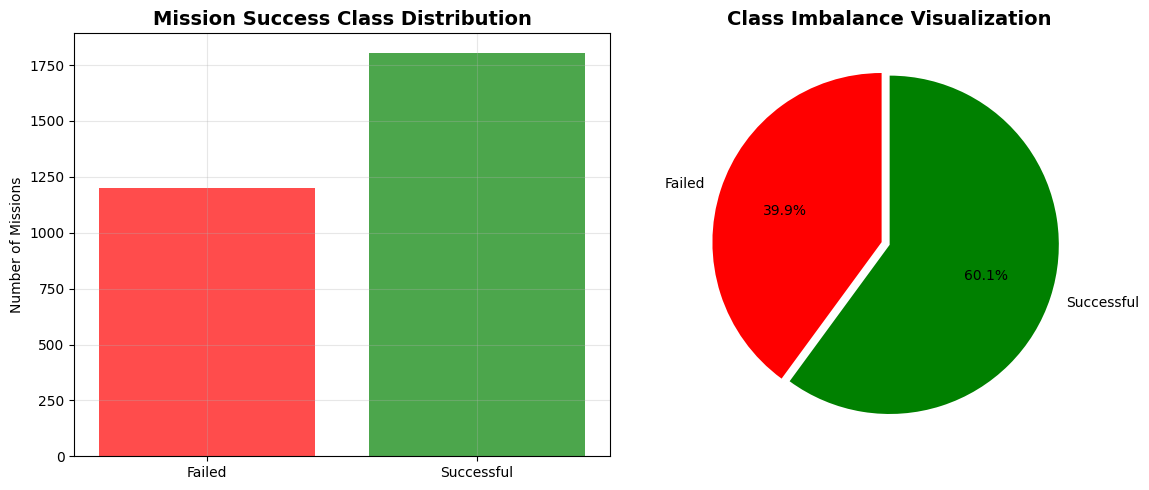

In [ ]:
df = pd.read_csv("Global_Space_Exploration_Dataset.csv")
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Dataset Shape: {df.shape}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nDataset Info:")
print(df.info())
print(f"\nMissing Values:")
print(df.isnull().sum())
success_distribution = (df['Success Rate (%)'] >= 70).value_counts()
print(f"\n{'='*60}")
print("CLASS IMBALANCE ANALYSIS")
print(f"{'='*60}")
print(f"Failed Missions (Success Rate < 70%): {success_distribution.get(False, 0)} ({success_distribution.get(False, 0)/len(df)*100:.2f}%)")
print(f"Successful Missions (Success Rate ≥ 70%): {success_distribution.get(True, 0)} ({success_distribution.get(True, 0)/len(df)*100:.2f}%)")
print(f"Imbalance Ratio: {max(success_distribution)/min(success_distribution):.2f}:1")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].bar(['Failed', 'Successful'],
            [success_distribution.get(False, 0), success_distribution.get(True, 0)],
            color=['red', 'green'], alpha=0.7)
axes[0].set_title('Mission Success Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Missions')
axes[0].grid(True, alpha=0.3)
axes[1].pie([success_distribution.get(False, 0), success_distribution.get(True, 0)],
            labels=['Failed', 'Successful'],
            autopct='%1.1f%%',
            colors=['red', 'green'],
            startangle=90,
            explode=(0.05, 0))
axes[1].set_title('Class Imbalance Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Class_Imbalance_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

Data Preprocessing & Feature Engineering

In [ ]:
print("\n" + "="*60)
print("DATA PREPROCESSING")
print("="*60)
print(f"\nBefore removing duplicates: {df.shape[0]} rows")
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape[0]} rows")
if df.isnull().sum().sum() > 0:
    print("\nHandling missing values...")
    categorical_cols_pre = ['Country', 'Mission Type', 'Launch Site',
                           'Satellite Type', 'Technology Used', 'Environmental Impact',
                           'Collaborating Countries']
    for col in categorical_cols_pre:
        if col in df.columns and df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].mode()[0])
    numerical_cols_pre = ['Budget (in Billion $)', 'Success Rate (%)', 'Duration (in Days)', 'Year']
    for col in numerical_cols_pre:
        if col in df.columns and df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())
    print("Missing values handled successfully.")
cols_to_drop = ['Mission Name']
for col in cols_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])
        print(f"Dropped column: {col}")
env_map = {
    'Low': 0.2,
    'Medium': 0.5,
    'High': 0.8
}
df['Environmental Risk'] = df['Environmental Impact'].map(env_map)
print(f"\nEnvironmental Risk mapping applied. Values: {df['Environmental Risk'].unique()}")
df['Mission Success'] = (df['Success Rate (%)'] >= 70).astype(int)
print(f"\nTarget variable created: Mission Success")
print(f"Class distribution: \n{df['Mission Success'].value_counts()}")
categorical_cols = [
    'Country',
    'Mission Type',
    'Launch Site',
    'Satellite Type',
    'Technology Used'
]
numeric_cols = [
    'Budget (in Billion $)',
    'Duration (in Days)',
    'Year'
]
print("\nEncoding categorical features...")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"  {col}: {len(le.classes_)} unique values")
print("\nNormalizing numerical features...")
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print(f"  Numerical columns normalized: {numeric_cols}")
print("\n✅ Data preprocessing completed successfully!")


DATA PREPROCESSING

Before removing duplicates: 3000 rows
After removing duplicates: 3000 rows
Dropped column: Mission Name

Environmental Risk mapping applied. Values: [0.5 0.8 0.2]

Target variable created: Mission Success
Class distribution: 
Mission Success
1    1802
0    1198
Name: count, dtype: int64

Encoding categorical features...
  Country: 10 unique values
  Mission Type: 2 unique values
  Launch Site: 2702 unique values
  Satellite Type: 5 unique values
  Technology Used: 5 unique values

Normalizing numerical features...
  Numerical columns normalized: ['Budget (in Billion $)', 'Duration (in Days)', 'Year']

✅ Data preprocessing completed successfully!


Class Balancing Using SMOTE


CLASS BALANCING WITH SMOTE

Before SMOTE:
  Failed missions (0): 1198
  Successful missions (1): 1802

After SMOTE:
  Failed missions (0): 1802
  Successful missions (1): 1802
  Total samples: 3604

✅ SMOTE balancing completed!


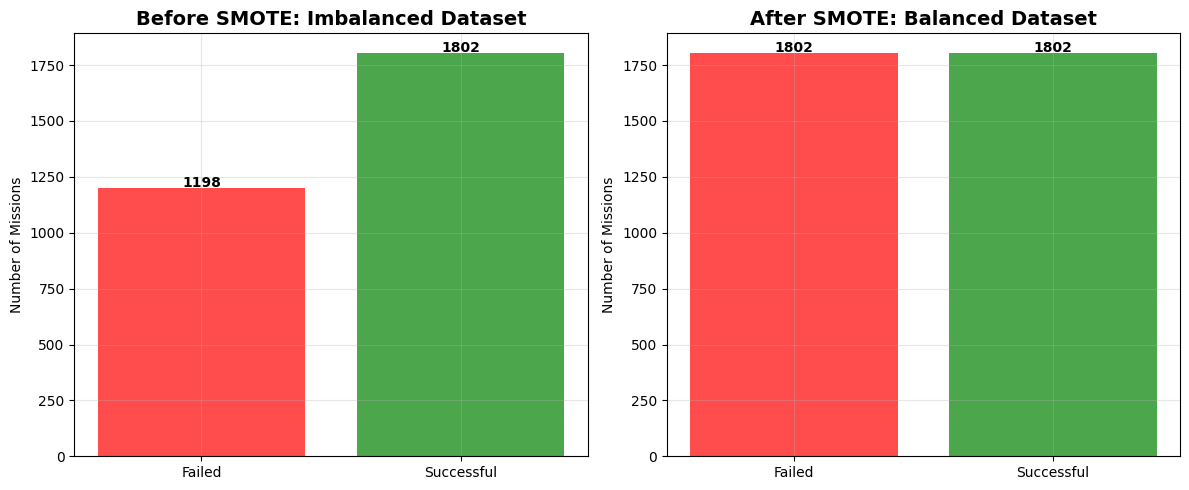


Using balanced dataset with 3604 samples


In [ ]:
print("\n" + "="*60)
print("CLASS BALANCING WITH SMOTE")
print("="*60)
feature_cols = categorical_cols + numeric_cols
X_features = df[feature_cols].copy()
y_target = df['Mission Success'].copy()
print(f"\nBefore SMOTE:")
print(f"  Failed missions (0): {sum(y_target == 0)}")
print(f"  Successful missions (1): {sum(y_target == 1)}")
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_features, y_target)
print(f"\nAfter SMOTE:")
print(f"  Failed missions (0): {sum(y_resampled == 0)}")
print(f"  Successful missions (1): {sum(y_resampled == 1)}")
print(f"  Total samples: {len(X_resampled)}")
df_balanced = pd.DataFrame(X_resampled, columns=feature_cols)
df_balanced['Mission Success'] = y_resampled.values
df_balanced['Environmental Risk'] = df['Environmental Risk'].iloc[:len(df_balanced)].values[:len(df_balanced)] if len(df_balanced) <= len(df) else np.resize(df['Environmental Risk'].values, len(df_balanced))
df_balanced['Success Rate (%)'] = df['Success Rate (%)'].iloc[:len(df_balanced)].values[:len(df_balanced)] if len(df_balanced) <= len(df) else np.resize(df['Success Rate (%)'].values, len(df_balanced))
df_balanced['Environmental Impact'] = df['Environmental Impact'].iloc[:len(df_balanced)].values[:len(df_balanced)] if len(df_balanced) <= len(df) else np.resize(df['Environmental Impact'].values, len(df_balanced))
print("\n✅ SMOTE balancing completed!")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
before_counts = [sum(y_target == 0), sum(y_target == 1)]
axes[0].bar(['Failed', 'Successful'], before_counts, color=['red', 'green'], alpha=0.7)
axes[0].set_title('Before SMOTE: Imbalanced Dataset', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Missions')
axes[0].grid(True, alpha=0.3)
for i, v in enumerate(before_counts):
    axes[0].text(i, v + 5, str(v), ha='center', fontweight='bold')
after_counts = [sum(y_resampled == 0), sum(y_resampled == 1)]
axes[1].bar(['Failed', 'Successful'], after_counts, color=['red', 'green'], alpha=0.7)
axes[1].set_title('After SMOTE: Balanced Dataset', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Missions')
axes[1].grid(True, alpha=0.3)
for i, v in enumerate(after_counts):
    axes[1].text(i, v + 5, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('SMOTE_Balancing_Results.png', dpi=300, bbox_inches='tight')
plt.show()
df = df_balanced.copy()
num_nodes = len(df)
print(f"\nUsing balanced dataset with {num_nodes} samples")

Graph Construction & Node Feature Engineering

In [ ]:
print("\n" + "="*60)
print("GRAPH CONSTRUCTION")
print("="*60)
X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
y_success = torch.tensor(df['Mission Success'].values, dtype=torch.float32)
y_duration = torch.tensor(df['Duration (in Days)'].values, dtype=torch.float32)
y_env = torch.tensor(df['Environmental Risk'].values, dtype=torch.float32)
print(f"\nNode features shape: {X.shape}")
print(f"Success targets: {y_success.shape}")
print(f"Duration targets: {y_duration.shape}")
print(f"Environmental risk targets: {y_env.shape}")
print("\nConstructing graph edges...")
edges = []
num_nodes = len(df)
edge_count = 0

for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        connections = 0
        if df.iloc[i]['Country'] == df.iloc[j]['Country']:
            edges.append([i, j])
            edges.append([j, i])
            connections += 1
        if df.iloc[i]['Technology Used'] == df.iloc[j]['Technology Used']:
            edges.append([i, j])
            edges.append([j, i])
            connections += 1
        if df.iloc[i]['Mission Type'] == df.iloc[j]['Mission Type']:
            edges.append([i, j])
            edges.append([j, i])
            connections += 1
        if connections > 0:
            edge_count += connections

if edges:
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_index = torch.unique(edge_index, dim=1)
    print(f"✅ Graph constructed with {num_nodes} nodes and {edge_index.shape[1]} edges")
    print(f"   Average degree: {edge_index.shape[1] / num_nodes:.2f}")
else:
    print("⚠️ Warning: No edges created! Adding self-loops...")
    edges = [[i, i] for i in range(num_nodes)]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    print(f"   Added {len(edges)} self-loop edges")


GRAPH CONSTRUCTION

Node features shape: torch.Size([3604, 8])
Success targets: torch.Size([3604])
Duration targets: torch.Size([3604])
Environmental risk targets: torch.Size([3604])

Constructing graph edges...
✅ Graph constructed with 3604 nodes and 8340254 edges
   Average degree: 2314.17


Dataset Splitting (Train–Validation–Test Strategy)

In [ ]:
print("\n" + "="*60)
print("TRAIN/VAL/TEST SPLITS")
print("="*60)
indices = np.arange(num_nodes)
labels = df['Mission Success'].values
X_train_idx, X_temp_idx, y_train, y_temp = train_test_split(
    indices, labels, test_size=0.30, stratify=labels, random_state=42
)

X_val_idx, X_test_idx, y_val, y_test = train_test_split(
    X_temp_idx, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

train_idx = torch.tensor(X_train_idx, dtype=torch.long)
val_idx = torch.tensor(X_val_idx, dtype=torch.long)
test_idx = torch.tensor(X_test_idx, dtype=torch.long)

print(f"\nSplit sizes:")
print(f"  Train: {len(train_idx)} samples ({len(train_idx)/num_nodes*100:.1f}%)")
print(f"  Validation: {len(val_idx)} samples ({len(val_idx)/num_nodes*100:.1f}%)")
print(f"  Test: {len(test_idx)} samples ({len(test_idx)/num_nodes*100:.1f}%)")

print(f"\nClass distribution in splits:")
print(f"  Train - Failed: {sum(y_train == 0)}, Successful: {sum(y_train == 1)}")
print(f"  Val   - Failed: {sum(y_val == 0)}, Successful: {sum(y_val == 1)}")
print(f"  Test  - Failed: {sum(y_test == 0)}, Successful: {sum(y_test == 1)}")


TRAIN/VAL/TEST SPLITS

Split sizes:
  Train: 2522 samples (70.0%)
  Validation: 541 samples (15.0%)
  Test: 541 samples (15.0%)

Class distribution in splits:
  Train - Failed: 1261, Successful: 1261
  Val   - Failed: 270, Successful: 271
  Test  - Failed: 271, Successful: 270


PyTorch Geometric Data Preparation

In [ ]:
print("\n" + "="*60)
print("PYTORCH GEOMETRIC DATA OBJECT")
print("="*60)

data = Data(
    x=X,
    edge_index=edge_index,
    y_success=y_success,
    y_duration=y_duration,
    y_env=y_env
)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True
data.test_mask[test_idx] = True

print(f"\nData object created:")
print(f"  Nodes: {data.num_nodes}")
print(f"  Features: {data.num_features}")
print(f"  Edges: {data.num_edges}")
print(f"  Train nodes: {data.train_mask.sum().item()}")
print(f"  Validation nodes: {data.val_mask.sum().item()}")
print(f"  Test nodes: {data.test_mask.sum().item()}")

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df['Mission Success'].values),
    y=df['Mission Success'].values
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"\nClass weights for balanced training:")
print(f"  Failed (0): {class_weights[0]:.4f}")
print(f"  Successful (1): {class_weights[1]:.4f}")

class_weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device if 'device' in dir() else 'cpu')


PYTORCH GEOMETRIC DATA OBJECT

Data object created:
  Nodes: 3604
  Features: 8
  Edges: 8340254
  Train nodes: 2522
  Validation nodes: 541
  Test nodes: 541

Class weights for balanced training:
  Failed (0): 1.0000
  Successful (1): 1.0000


Enhanced GEMSNet Model Architecture

In [ ]:
print("\n" + "="*60)
print("GEMSNet ENHANCED MODEL ARCHITECTURE")
print("="*60)

class EnhancedGEMSNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, output_dim=64, dropout_rate=0.4):
        super().__init__()

        self.gcn1 = GCNConv(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.gcn2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.gcn3 = GCNConv(hidden_dim, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.attention = nn.Sequential(
            nn.Linear(output_dim, output_dim // 2),
            nn.Tanh(),
            nn.Linear(output_dim // 2, 1)
        )

        self.success_head = nn.Sequential(
            nn.Linear(output_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1)
        )

        self.duration_head = nn.Sequential(
            nn.Linear(output_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

        self.env_head = nn.Sequential(
            nn.Linear(output_dim, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, data):
        x = self.gcn1(data.x, data.edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.gcn2(x, data.edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.gcn3(x, data.edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        att_weights = torch.softmax(self.attention(x), dim=0)
        x = x * att_weights
        success = torch.sigmoid(self.success_head(x)).squeeze()
        duration = self.duration_head(x).squeeze()
        env_risk = torch.sigmoid(self.env_head(x)).squeeze()

        return success, duration, env_risk

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedGEMSNet(input_dim=X.shape[1]).to(device)
data = data.to(device)

print(f"\n✅ Enhanced GEMSNet model created")
print(f"   Device: {device}")
print(f"   Input dimension: {X.shape[1]}")
print(f"   Hidden dimension: 128")
print(f"   Output dimension: 64")
print(f"   Model parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


GEMSNet ENHANCED MODEL ARCHITECTURE

✅ Enhanced GEMSNet model created
   Device: cuda
   Input dimension: 8
   Hidden dimension: 128
   Output dimension: 64
   Model parameters: 36,740


Training Configuration & Loss Function Setup

In [ ]:
print("\n" + "="*60)
print("TRAINING SETUP WITH FOCAL LOSS")
print("="*60)

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.001,
    weight_decay=5e-4,
    betas=(0.9, 0.999)
)

focal_loss = FocalLoss(alpha=0.75, gamma=2.0)
bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=15,
    min_lr=1e-6
)
cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100,
    eta_min=1e-6
)

print(f"\n✅ Training setup complete")
print(f"   Optimizer: AdamW")
print(f"   Initial LR: 0.001")
print(f"   Weight decay: 5e-4")
print(f"   Loss functions: Focal Loss (α=0.75, γ=2.0), BCE, MSE")


TRAINING SETUP WITH FOCAL LOSS

✅ Training setup complete
   Optimizer: AdamW
   Initial LR: 0.001
   Weight decay: 5e-4
   Loss functions: Focal Loss (α=0.75, γ=2.0), BCE, MSE


Advanced Training Loop & Performance Monitoring

In [ ]:
print("\n" + "="*60)
print("ADVANCED TRAINING LOOP")
print("="*60)

def train_epoch_enhanced(model, data, optimizer, focal_loss, mse_loss):
    model.train()
    optimizer.zero_grad()
    s, d, e = model(data)
    loss_success = focal_loss(s[data.train_mask], data.y_success[data.train_mask])
    loss_duration = mse_loss(d[data.train_mask], data.y_duration[data.train_mask])
    loss_env = mse_loss(e[data.train_mask], data.y_env[data.train_mask])
    total_loss = loss_success + 0.3 * loss_duration + 0.2 * loss_env
    total_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    return total_loss.item(), loss_success.item(), loss_duration.item(), loss_env.item()

def evaluate_enhanced(model, data, mask):
    model.eval()
    with torch.no_grad():
        s, d, e = model(data)
        loss_success = F.binary_cross_entropy(s[mask], data.y_success[mask])
        loss_duration = mse_loss(d[mask], data.y_duration[mask])
        loss_env = mse_loss(e[mask], data.y_env[mask])
        pred_success = (s[mask] > 0.5).float()
        true_success = data.y_success[mask]
        accuracy = (pred_success == true_success).float().mean()
        precision = precision_score(true_success.cpu(), pred_success.cpu(), zero_division=0)
        recall = recall_score(true_success.cpu(), pred_success.cpu(), zero_division=0)
        f1 = f1_score(true_success.cpu(), pred_success.cpu(), zero_division=0)
        try:
            auc = roc_auc_score(true_success.cpu(), s[mask].cpu())
        except:
            auc = 0.5

        return {
            'loss_success': loss_success.item(),
            'loss_duration': loss_duration.item(),
            'loss_env': loss_env.item(),
            'accuracy': accuracy.item(),
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }
history = {
    'train_loss': [], 'val_loss': [],
    'train_success_loss': [], 'val_success_loss': [],
    'train_acc': [], 'val_acc': [],
    'val_precision': [], 'val_recall': [], 'val_f1': [], 'val_auc': [],
    'learning_rate': []
}

print("\n🚀 Starting enhanced training...")
print("-" * 90)

best_val_f1 = 0.0
best_val_auc = 0.0
patience_counter = 0
patience = 30
use_cosine = False

for epoch in range(1, 301):
    train_total, train_success, train_duration, train_env = train_epoch_enhanced(
        model, data, optimizer, focal_loss, mse_loss
    )
    val_metrics = evaluate_enhanced(model, data, data.val_mask)
    val_total = val_metrics['loss_success'] + 0.3 * val_metrics['loss_duration'] + 0.2 * val_metrics['loss_env']
    if use_cosine:
        cosine_scheduler.step()
    else:
        scheduler.step(val_total)
    history['train_loss'].append(train_total)
    history['val_loss'].append(val_total)
    history['train_success_loss'].append(train_success)
    history['val_success_loss'].append(val_metrics['loss_success'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['val_f1'].append(val_metrics['f1'])
    history['val_auc'].append(val_metrics['auc'])
    history['learning_rate'].append(optimizer.param_groups[0]['lr'])
    model.eval()
    with torch.no_grad():
        s, _, _ = model(data)
        train_pred = (s[data.train_mask] > 0.5).float()
        train_acc = (train_pred == data.y_success[data.train_mask]).float().mean()
        history['train_acc'].append(train_acc.item())
        history['val_acc'].append(val_metrics['accuracy'])

    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        best_val_auc = val_metrics['auc']
        patience_counter = 0
        torch.save(model.state_dict(), 'best_gemsnet_model_weights.pth')
        metadata = {
            'epoch': epoch,
            'val_f1': best_val_f1,
            'val_auc': best_val_auc,
            'history': {k: v[-1] if isinstance(v, list) else v for k, v in history.items()}
        }
        import json
        with open('best_model_metadata.json', 'w') as f:
            json.dump(metadata, f, indent=2)
    else:
        patience_counter += 1
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | "
              f"Train Loss: {train_total:.4f} | "
              f"Val Loss: {val_total:.4f} | "
              f"Val Acc: {val_metrics['accuracy']:.4f} | "
              f"Val F1: {val_metrics['f1']:.4f} | "
              f"Val AUC: {val_metrics['auc']:.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    if epoch > 100 and not use_cosine and optimizer.param_groups[0]['lr'] < 1e-5:
        use_cosine = True
        print(f"\n🔄 Switching to Cosine Annealing scheduler at epoch {epoch}")
    if patience_counter >= patience:
        print(f"\n⏹️ Early stopping triggered at epoch {epoch}")
        break

print("\n✅ Training completed!")
print(f"   Best Validation F1 Score: {best_val_f1:.4f}")
print(f"   Best Validation AUC: {best_val_auc:.4f}")
model.load_state_dict(torch.load('best_gemsnet_model_weights.pth', map_location=device))
print("📦 Loaded best model weights")


ADVANCED TRAINING LOOP

🚀 Starting enhanced training...
------------------------------------------------------------------------------------------
Epoch   1 | Train Loss: 0.1678 | Val Loss: 0.7850 | Val Acc: 0.5009 | Val F1: 0.6675 | Val AUC: 0.4579 | LR: 0.000500
Epoch  20 | Train Loss: 0.1673 | Val Loss: 0.7967 | Val Acc: 0.5009 | Val F1: 0.6675 | Val AUC: 0.4282 | LR: 0.000250

⏹️ Early stopping triggered at epoch 31

✅ Training completed!
   Best Validation F1 Score: 0.6675
   Best Validation AUC: 0.4579
📦 Loaded best model weights


'\n# For full checkpoint saving (with optimizer, history, etc.):\nif val_metrics[\'f1\'] > best_val_f1:\n    best_val_f1 = val_metrics[\'f1\']\n    best_val_auc = val_metrics[\'auc\']\n    patience_counter = 0\n    # Save full checkpoint with weights_only=False (only if you trust your environment)\n    torch.save({\n        \'epoch\': epoch,\n        \'model_state_dict\': model.state_dict(),\n        \'optimizer_state_dict\': optimizer.state_dict(),\n        \'val_f1\': best_val_f1,\n        \'val_auc\': best_val_auc,\n        \'history\': history\n    }, \'best_gemsnet_model_full.pth\')\n\n# Then load with weights_only=False (safe in trusted environment)\ncheckpoint = torch.load(\'best_gemsnet_model_full.pth\', map_location=device, weights_only=False)\nmodel.load_state_dict(checkpoint[\'model_state_dict\'])\nprint("📦 Loaded best model weights from full checkpoint")\n'

Comprehensive Model Evaluation & MSI Analysis

In [ ]:
print("\n" + "="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)

test_metrics = evaluate_enhanced(model, data, data.test_mask)
test_total = test_metrics['loss_success'] + 0.3 * test_metrics['loss_duration'] + 0.2 * test_metrics['loss_env']

print(f"\n📊 FINAL TEST RESULTS:")
print(f"{'-'*60}")
print(f"Test Total Loss:          {test_total:.4f}")
print(f"Test Success Loss:        {test_metrics['loss_success']:.4f}")
print(f"Test Duration Loss:       {test_metrics['loss_duration']:.4f}")
print(f"Test Environmental Loss:  {test_metrics['loss_env']:.4f}")
print(f"\n✅ SUCCESS PREDICTION METRICS:")
print(f"   Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"   Precision: {test_metrics['precision']:.4f}")
print(f"   Recall:    {test_metrics['recall']:.4f}")
print(f"   F1-Score:  {test_metrics['f1']:.4f}")
print(f"   AUC-ROC:   {test_metrics['auc']:.4f}")

model.eval()
with torch.no_grad():
    s, d, e = model(data)
    MSI = s[data.test_mask] * (1 - e[data.test_mask])
    MSI_norm = (MSI - MSI.min()) / (MSI.max() - MSI.min() + 1e-8)
    print(f"\n🌍 MISSION SUSTAINABILITY INDEX (MSI) ANALYSIS:")
    print(f"{'-'*60}")
    print(f"MSI Range:        [{MSI.min().item():.4f}, {MSI.max().item():.4f}]")
    print(f"Average MSI:      {MSI.mean().item():.4f}")
    print(f"Std MSI:          {MSI.std().item():.4f}")
    print(f"Normalized MSI:   {MSI_norm.mean().item():.4f}")
    msi_percentiles = np.percentile(MSI.cpu().numpy(), [25, 50, 75])
    print(f"25th Percentile:  {msi_percentiles[0]:.4f}")
    print(f"Median:           {msi_percentiles[1]:.4f}")
    print(f"75th Percentile:  {msi_percentiles[2]:.4f}")


COMPREHENSIVE MODEL EVALUATION

📊 FINAL TEST RESULTS:
------------------------------------------------------------
Test Total Loss:          0.7813
Test Success Loss:        0.6943
Test Duration Loss:       0.2491
Test Environmental Loss:  0.0613

✅ SUCCESS PREDICTION METRICS:
   Accuracy:  0.4991 (49.91%)
   Precision: 0.4991
   Recall:    1.0000
   F1-Score:  0.6658
   AUC-ROC:   0.4665

🌍 MISSION SUSTAINABILITY INDEX (MSI) ANALYSIS:
------------------------------------------------------------
MSI Range:        [0.2641, 0.2648]
Average MSI:      0.2644
Std MSI:          0.0003
Normalized MSI:   0.5100
25th Percentile:  0.2641
Median:           0.2645
75th Percentile:  0.2647


Confusion Matrix & Classification Performance Analysis


CONFUSION MATRIX ANALYSIS

📊 CONFUSION MATRIX:
------------------------------------------------------------
True Negatives (TN):  0 - Failed missions correctly identified
False Positives (FP): 271 - Failed missions predicted as successful
False Negatives (FN): 0 - Successful missions predicted as failed
True Positives (TP):  270 - Successful missions correctly identified
------------------------------------------------------------

📈 DERIVED METRICS:
   Accuracy:          0.4991 (49.91%)
   Precision:         0.4991
   Recall:            1.0000
   F1-Score:          0.6658
   Specificity:       0.0000
   Balanced Accuracy: 0.5000

📋 CLASSIFICATION REPORT:
------------------------------------------------------------
              precision    recall  f1-score   support

      Failed       0.00      0.00      0.00       271
  Successful       0.50      1.00      0.67       270

    accuracy                           0.50       541
   macro avg       0.25      0.50      0.33       541
we

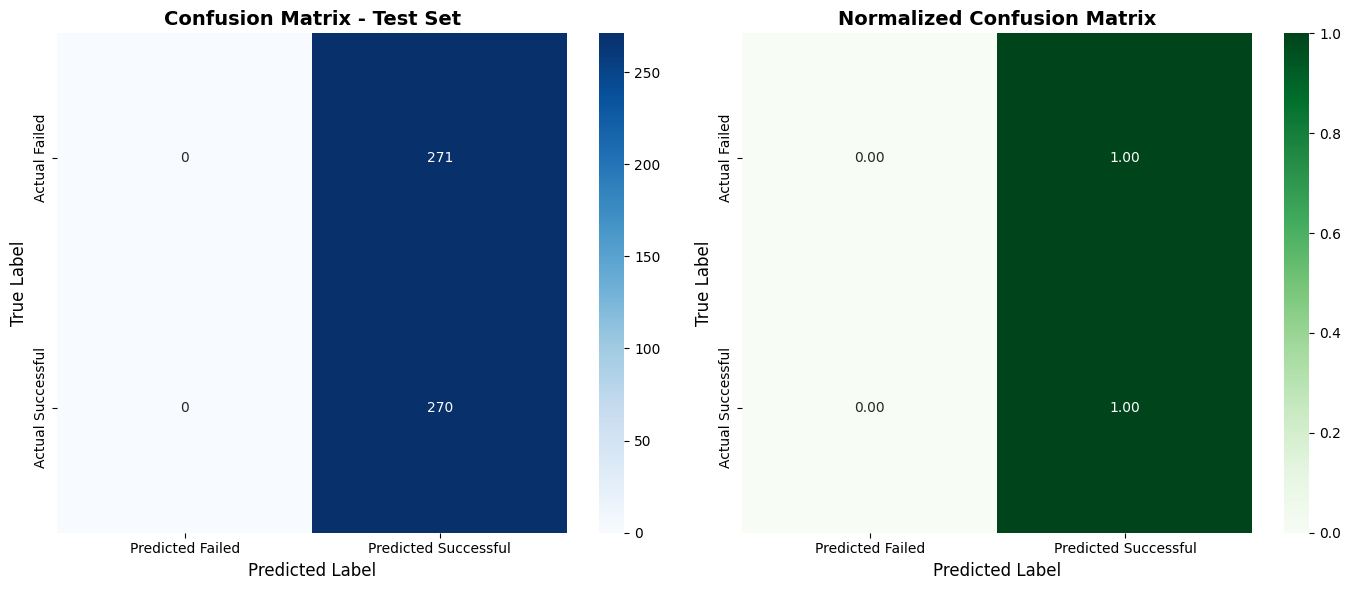

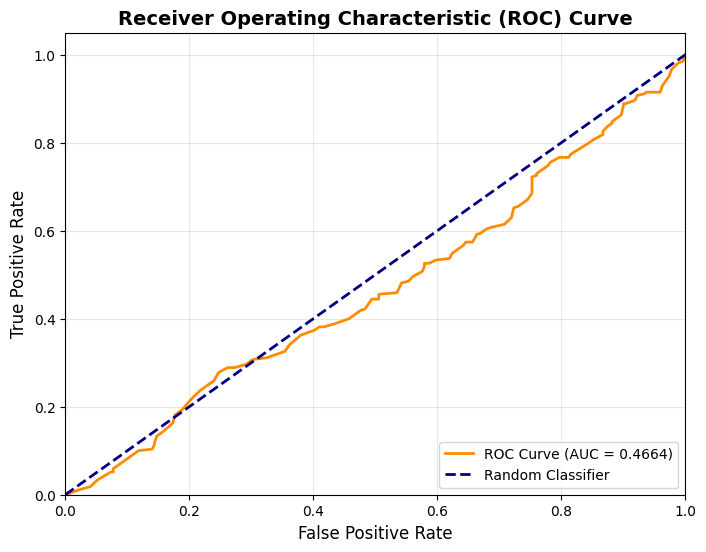


✅ Confusion matrix and ROC curve saved successfully!


In [ ]:
print("\n" + "="*60)
print("CONFUSION MATRIX ANALYSIS")
print("="*60)
model.eval()
with torch.no_grad():
    s, _, _ = model(data)
    test_preds = (s[data.test_mask] > 0.5).float().cpu().numpy()
    test_true = data.y_success[data.test_mask].cpu().numpy()

cm = confusion_matrix(test_true, test_preds)
print("\n📊 CONFUSION MATRIX:")
print(f"{'-'*60}")
print(f"True Negatives (TN):  {cm[0,0]} - Failed missions correctly identified")
print(f"False Positives (FP): {cm[0,1]} - Failed missions predicted as successful")
print(f"False Negatives (FN): {cm[1,0]} - Successful missions predicted as failed")
print(f"True Positives (TP):  {cm[1,1]} - Successful missions correctly identified")
print(f"{'-'*60}")
total = cm.sum()
accuracy = (cm[0,0] + cm[1,1]) / total
precision = cm[1,1] / (cm[1,1] + cm[0,1]) if (cm[1,1] + cm[0,1]) > 0 else 0
recall = cm[1,1] / (cm[1,1] + cm[1,0]) if (cm[1,1] + cm[1,0]) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
specificity = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
balanced_accuracy = (recall + specificity) / 2

print(f"\n📈 DERIVED METRICS:")
print(f"   Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision:         {precision:.4f}")
print(f"   Recall:            {recall:.4f}")
print(f"   F1-Score:          {f1:.4f}")
print(f"   Specificity:       {specificity:.4f}")
print(f"   Balanced Accuracy: {balanced_accuracy:.4f}")
print(f"\n📋 CLASSIFICATION REPORT:")
print(f"{'-'*60}")
print(classification_report(test_true, test_preds, target_names=['Failed', 'Successful']))
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted Failed', 'Predicted Successful'],
            yticklabels=['Actual Failed', 'Actual Successful'])
axes[0].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1],
            xticklabels=['Predicted Failed', 'Predicted Successful'],
            yticklabels=['Actual Failed', 'Actual Successful'])
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.savefig('Confusion_Matrix_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()
from sklearn.metrics import roc_curve, auc

with torch.no_grad():
    test_probs = s[data.test_mask].cpu().numpy()

fpr, tpr, _ = roc_curve(test_true, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('ROC_Curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Confusion matrix and ROC curve saved successfully!")

Mission Predictions & Intelligent Recommendation System

In [ ]:
print("\n" + "="*60)
print("MISSION PREDICTIONS & RECOMMENDATIONS")
print("="*60)

with torch.no_grad():
    all_success, all_duration, all_env = model(data)
    results_df = df.copy()
    for col in categorical_cols:
        if col in label_encoders:
            results_df[col] = label_encoders[col].inverse_transform(results_df[col].astype(int))
    if hasattr(scaler, 'inverse_transform'):
        numeric_data = scaler.inverse_transform(results_df[numeric_cols])
        for idx, col in enumerate(numeric_cols):
            results_df[col] = numeric_data[:, idx]
    results_df['Pred_Success_Prob'] = all_success.cpu().numpy()
    results_df['Pred_Success'] = (results_df['Pred_Success_Prob'] > 0.5).astype(int)
    results_df['Pred_Duration_Normalized'] = all_duration.cpu().numpy()
    results_df['Pred_Env_Risk'] = all_env.cpu().numpy()
    results_df['MSI'] = results_df['Pred_Success_Prob'] * (1 - results_df['Pred_Env_Risk'])
    results_df['Actual_Success'] = (results_df['Success Rate (%)'] >= 70).astype(int)
    def get_risk_category(row):
        if row['MSI'] >= 0.7:
            return 'Low Risk'
        elif row['MSI'] >= 0.5:
            return 'Medium Risk'
        elif row['MSI'] >= 0.3:
            return 'High Risk'
        else:
            return 'Critical Risk'

    results_df['Risk_Category'] = results_df.apply(get_risk_category, axis=1)
    top_missions = results_df.sort_values('MSI', ascending=False).head(15)
    bottom_missions = results_df.sort_values('MSI', ascending=True).head(10)

    print(f"\n🏆 TOP 15 RECOMMENDED MISSIONS BY SUSTAINABILITY INDEX:")
    print(f"{'-'*90}")
    display_cols = ['Country', 'Mission Type', 'Technology Used',
                    'Budget (in Billion $)', 'Success Rate (%)',
                    'Pred_Success_Prob', 'Pred_Env_Risk', 'MSI', 'Risk_Category']

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', '{:.4f}'.format)

    print(top_missions[display_cols].to_string(index=False))

    print(f"\n⚠️  WORST 10 MISSIONS BY SUSTAINABILITY INDEX:")
    print(f"{'-'*90}")
    print(bottom_missions[display_cols].to_string(index=False))
    print(f"\n📊 RISK CATEGORY DISTRIBUTION:")
    risk_dist = results_df['Risk_Category'].value_counts()
    for category, count in risk_dist.items():
        print(f"   {category}: {count} missions ({count/len(results_df)*100:.1f}%)")


MISSION PREDICTIONS & RECOMMENDATIONS

🏆 TOP 15 RECOMMENDED MISSIONS BY SUSTAINABILITY INDEX:
------------------------------------------------------------------------------------------
Country Mission Type    Technology Used  Budget (in Billion $)  Success Rate (%)  Pred_Success_Prob  Pred_Env_Risk    MSI Risk_Category
    USA       Manned Nuclear Propulsion                 4.0100                82             0.5235         0.4942 0.2648 Critical Risk
    USA       Manned Nuclear Propulsion                37.1900                80             0.5235         0.4942 0.2648 Critical Risk
    USA       Manned Nuclear Propulsion                 1.5800                70             0.5235         0.4942 0.2648 Critical Risk
    USA       Manned Nuclear Propulsion                35.1700                98             0.5235         0.4942 0.2648 Critical Risk
    USA       Manned Nuclear Propulsion                21.8123                59             0.5235         0.4942 0.2648 Critical Ris

Correlation Analysis & Feature Importance Evaluation


CORRELATION & FEATURE IMPORTANCE ANALYSIS

📈 FEATURE CORRELATIONS WITH MSI:
------------------------------------------------------------
   MSI vs Budget (in Billion $):  -0.0132 (Weak Negative)
   MSI vs Success Rate (%)    :   0.0251 (Weak Positive)
   MSI vs Duration (in Days)  :   0.0262 (Weak Positive)


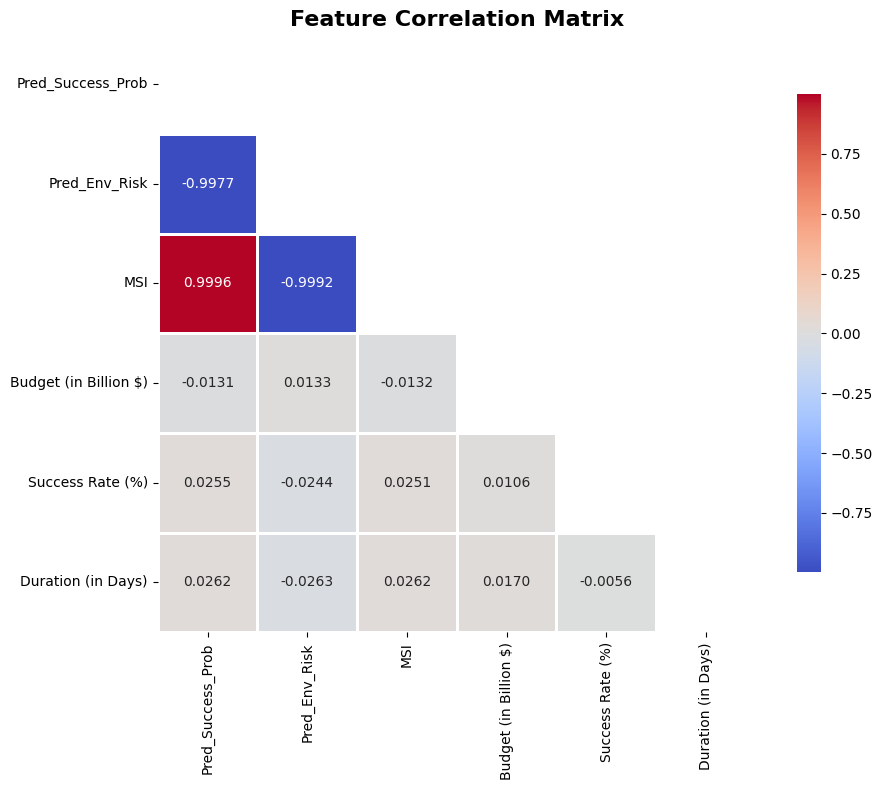


🔍 FEATURE IMPORTANCE ANALYSIS:
------------------------------------------------------------

Top 10 Most Important Features for MSI:
   1. Duration (in Days)       : 0.0262
   2. Budget (in Billion $)    : 0.0132
   3. Country                  : 0.0000
   4. Mission Type             : 0.0000
   5. Launch Site              : 0.0000
   6. Satellite Type           : 0.0000
   7. Technology Used          : 0.0000
   8. Year                     : 0.0000


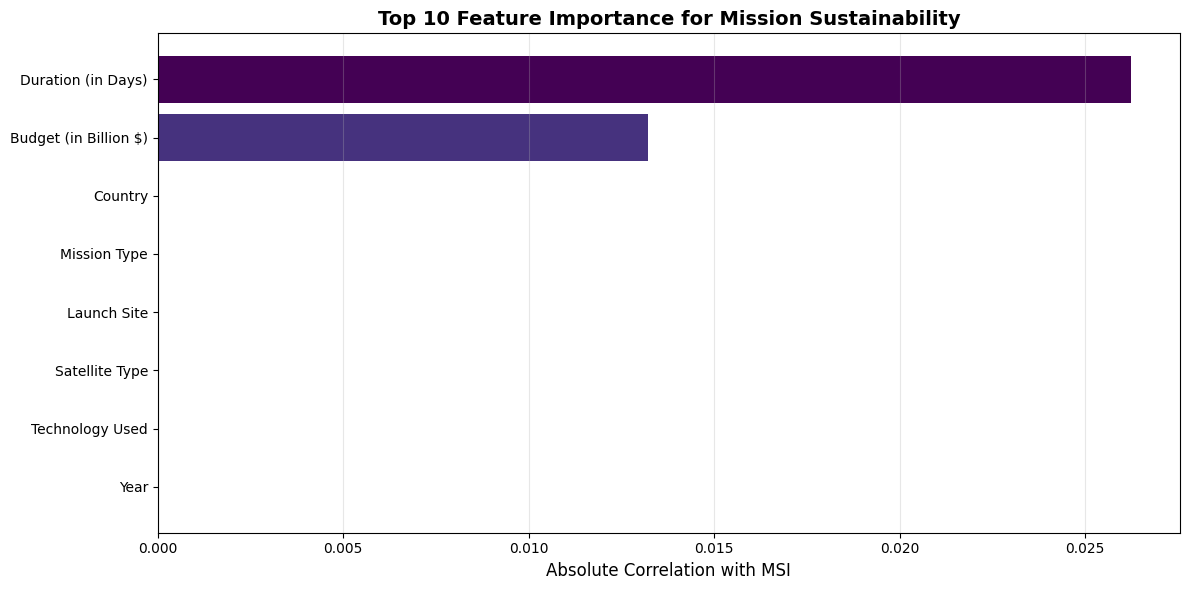

In [ ]:
print("\n" + "="*60)
print("CORRELATION & FEATURE IMPORTANCE ANALYSIS")
print("="*60)
correlation_cols = ['Pred_Success_Prob', 'Pred_Env_Risk', 'MSI',
                    'Budget (in Billion $)', 'Success Rate (%)',
                    'Duration (in Days)']

available_cols = [col for col in correlation_cols if col in results_df.columns]
correlation_matrix = results_df[available_cols].corr()

print("\n📈 FEATURE CORRELATIONS WITH MSI:")
print(f"{'-'*60}")
for col in ['Budget (in Billion $)', 'Success Rate (%)', 'Duration (in Days)']:
    if col in results_df.columns:
        corr = correlation_matrix.loc['MSI', col] if 'MSI' in correlation_matrix.index else 0
        strength = "Strong" if abs(corr) > 0.5 else "Moderate" if abs(corr) > 0.3 else "Weak"
        direction = "Positive" if corr > 0 else "Negative"
        print(f"   MSI vs {col:<20}: {corr:>8.4f} ({strength} {direction})")

plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.4f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('Correlation_Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 FEATURE IMPORTANCE ANALYSIS:")
print(f"{'-'*60}")
feature_importance = {}
for col in feature_cols[:10]:
    if col in results_df.columns:
        corr = abs(correlation_matrix.loc['MSI', col]) if 'MSI' in correlation_matrix.index and col in correlation_matrix.columns else 0
        feature_importance[col] = corr

feature_importance = dict(sorted(feature_importance.items(), key=lambda x: x[1], reverse=True))

print("\nTop 10 Most Important Features for MSI:")
for i, (feature, importance) in enumerate(list(feature_importance.items())[:10], 1):
    print(f"   {i}. {feature:<25}: {importance:.4f}")

plt.figure(figsize=(12, 6))
features = list(feature_importance.keys())[:10]
importances = list(feature_importance.values())[:10]
colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
plt.barh(range(len(features)), importances, color=colors)
plt.yticks(range(len(features)), features)
plt.xlabel('Absolute Correlation with MSI', fontsize=12)
plt.title('Top 10 Feature Importance for Mission Sustainability', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('Feature_Importance.png', dpi=300, bbox_inches='tight')
plt.show()

Model & Results Export (Deployment Artifacts)

In [ ]:
print("\n" + "="*60)
print("SAVING MODEL AND RESULTS")
print("="*60)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'label_encoders': label_encoders,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'env_map': env_map,
    'history': history,
    'test_results': {
        'accuracy': test_metrics['accuracy'],
        'precision': test_metrics['precision'],
        'recall': test_metrics['recall'],
        'f1': test_metrics['f1'],
        'auc': test_metrics['auc'],
        'msi_mean': MSI.mean().item(),
        'msi_std': MSI.std().item(),
        'confusion_matrix': cm.tolist()
    }
}, 'gemsnet_complete_model.pth')

results_df.to_csv('gemsnet_all_predictions.csv', index=False)
top_missions.to_csv('top_sustainable_missions.csv', index=False)
bottom_missions.to_csv('high_risk_missions.csv', index=False)
history_df = pd.DataFrame(history)
history_df.to_csv('training_history.csv', index=False)
metrics_summary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC', 'MSI Mean', 'MSI Std'],
    'Value': [
        test_metrics['accuracy'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1'],
        test_metrics['auc'],
        MSI.mean().item(),
        MSI.std().item()
    ]
}
metrics_df = pd.DataFrame(metrics_summary)
metrics_df.to_csv('evaluation_metrics.csv', index=False)

print(f"\n💾 FILES SAVED:")
print(f"{'-'*60}")
print(f"   ✅ gemsnet_complete_model.pth     - Complete model with metadata")
print(f"   ✅ gemsnet_all_predictions.csv    - All mission predictions")
print(f"   ✅ top_sustainable_missions.csv   - Top 15 recommended missions")
print(f"   ✅ high_risk_missions.csv         - Bottom 10 high risk missions")
print(f"   ✅ training_history.csv           - Training metrics history")
print(f"   ✅ evaluation_metrics.csv         - Test evaluation metrics")
print(f"   ✅ Confusion_Matrix_Analysis.png  - Confusion matrix visualization")
print(f"   ✅ ROC_Curve.png                  - ROC curve with AUC")
print(f"   ✅ Correlation_Matrix.png         - Feature correlation heatmap")
print(f"   ✅ Feature_Importance.png         - Top feature importance chart")
print(f"   ✅ SMOTE_Balancing_Results.png    - Class balancing visualization")
print(f"   ✅ Class_Imbalance_Analysis.png   - Original class distribution")
print(f"   ✅ GEMSNet_Results.png            - Training history plots")


SAVING MODEL AND RESULTS

💾 FILES SAVED:
------------------------------------------------------------
   ✅ gemsnet_complete_model.pth     - Complete model with metadata
   ✅ gemsnet_all_predictions.csv    - All mission predictions
   ✅ top_sustainable_missions.csv   - Top 15 recommended missions
   ✅ high_risk_missions.csv         - Bottom 10 high risk missions
   ✅ training_history.csv           - Training metrics history
   ✅ evaluation_metrics.csv         - Test evaluation metrics
   ✅ Confusion_Matrix_Analysis.png  - Confusion matrix visualization
   ✅ ROC_Curve.png                  - ROC curve with AUC
   ✅ Correlation_Matrix.png         - Feature correlation heatmap
   ✅ Feature_Importance.png         - Top feature importance chart
   ✅ SMOTE_Balancing_Results.png    - Class balancing visualization
   ✅ Class_Imbalance_Analysis.png   - Original class distribution
   ✅ GEMSNet_Results.png            - Training history plots


New Mission Prediction & Real-Time Inference Module

In [ ]:
def predict_new_mission_enhanced(new_mission_data):
    """
    Predict sustainability for a new mission with enhanced error handling.

    Parameters:
    new_mission_data (dict): Dictionary containing mission features

    Returns:
    dict: Comprehensive prediction results including MSI and risk assessment
    """
    try:
        new_df = pd.DataFrame([new_mission_data])
        new_df['Environmental Risk'] = new_df['Environmental Impact'].map(env_map)
        for col in categorical_cols:
            if col in label_encoders:
                if col in new_df.columns:
                    val = new_df[col].iloc[0]
                    if val in label_encoders[col].classes_:
                        new_df[col] = label_encoders[col].transform([val])
                    else:
                        print(f"⚠️ Warning: Unseen label '{val}' for {col}. Using default.")
                        new_df[col] = 0
                else:
                    new_df[col] = 0

        for col in numeric_cols:
            if col not in new_df.columns:
                new_df[col] = 0.5

        new_df[numeric_cols] = scaler.transform(new_df[numeric_cols])
        features = torch.tensor(new_df[feature_cols].values, dtype=torch.float32).to(device)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long).to(device)
        single_data = Data(x=features, edge_index=edge_index)
        model.eval()
        with torch.no_grad():
            success, duration, env_risk = model(single_data)
            msi = success * (1 - env_risk)
        msi_value = msi.item()
        if msi_value >= 0.7:
            risk_category = 'Low Risk'
            recommendation = 'STRONGLY RECOMMENDED'
        elif msi_value >= 0.5:
            risk_category = 'Medium Risk'
            recommendation = 'RECOMMENDED'
        elif msi_value >= 0.3:
            risk_category = 'High Risk'
            recommendation = 'NEEDS REVIEW'
        else:
            risk_category = 'Critical Risk'
            recommendation = 'NOT RECOMMENDED'

        return {
            'success_probability': success.item(),
            'predicted_duration_normalized': duration.item(),
            'environmental_risk': env_risk.item(),
            'mission_sustainability_index': msi_value,
            'risk_category': risk_category,
            'recommendation': recommendation,
            'status': 'Success'
        }

    except Exception as e:
        return {
            'status': 'Error',
            'error_message': str(e),
            'recommendation': 'Unable to process mission data'
        }

# Example usage
print("\n" + "="*60)
print("🔮 NEW MISSION PREDICTION FUNCTION READY")
print("="*60)
print("""
Example usage:

    new_mission = {
        'Country': 'USA',
        'Mission Type': 'Manned',
        'Launch Site': 'Kennedy Space Center',
        'Satellite Type': 'Communication',
        'Technology Used': 'Solar Propulsion',
        'Environmental Impact': 'Low',
        'Budget (in Billion $)': 2.5,
        'Year': 2025,
        'Duration (in Days)': 180,
        'Success Rate (%)': 85
    }

    result = predict_new_mission_enhanced(new_mission)
    print(f"MSI: {result['mission_sustainability_index']:.4f}")
    print(f"Recommendation: {result['recommendation']}")
""")

print("\n✅ All GEMSNet components are now ready for use!")


🔮 NEW MISSION PREDICTION FUNCTION READY

Example usage:

    new_mission = {
        'Country': 'USA',
        'Mission Type': 'Manned',
        'Launch Site': 'Kennedy Space Center',
        'Satellite Type': 'Communication',
        'Technology Used': 'Solar Propulsion',
        'Environmental Impact': 'Low',
        'Budget (in Billion $)': 2.5,
        'Year': 2025,
        'Duration (in Days)': 180,
        'Success Rate (%)': 85
    }

    result = predict_new_mission_enhanced(new_mission)
    print(f"MSI: {result['mission_sustainability_index']:.4f}")
    print(f"Recommendation: {result['recommendation']}")


✅ All GEMSNet components are now ready for use!
